In [1]:
import datetime
import os
import random
import readline
from datetime import date

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import netCDF4
import numpy
import pandas
import scipy
import seaborn
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import colors, font_manager, pyplot
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from scipy import fft, linalg, stats
from scipy.stats import poisson, ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V5.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V5.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V5.csv')
    Time = []
    Start_Time = []
    End_Time = []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [7]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [8]:
# Define Cyclone Type, Set Shape and Colour Code
SLP_Colours = ['darkviolet', 'mediumvioletred', 'magenta', 'red', 'orangered', \
'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', 'deepskyblue', 'cyan']
SLP_Bounds = Create_Bins(900,1010,10)
def Cyclone_Type(DF, ET_DF, Storm_List):
# Cyclone Type and Shape Code
    Cyclone_Type = []
    Plot_Shape = []
    for i in range(len(DF["Storm Phase"])):
        if DF["Storm Phase"][i] == "Tropical":
            Plot_Shape.append('o')
        elif DF["Storm Phase"][i] == "Transition":
            Plot_Shape.append('s')
        elif DF["Storm Phase"][i] == "Extratropical":
            Plot_Shape.append('^')
        else:
            print (DF["Storm Type"][i])
    DF["Plot Shape"] = Plot_Shape
#    
# SLP Colour Code
    Plot_Colour = []
    for i in range(len(DF["SLP(hPa)"])):
        for k in range(len(SLP_Colours)):
            if k == 0:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k]:
                    Plot_Colour.append(SLP_Colours[k])
            elif k != len(SLP_Colours)-1:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k] and DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
            else:
                if DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
    DF["Plot Colour"] = Plot_Colour
    return (DF)

In [9]:
Control_Data_Plot = Cyclone_Type(Control_Data, Control_ET, Control_Codes["New Code"])
RCP45_Data_Plot = Cyclone_Type(RCP45_Data, RCP45_ET, RCP45_Codes["New Code"])
RCP85_Data_Plot = Cyclone_Type(RCP85_Data, RCP85_ET, RCP85_Codes["New Code"])

In [10]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    DF_Storm = DF_Storm.drop("index", axis=1)
    return (DF_Storm)

In [11]:
# Create Legend
def Plot_TC_Legend(Loc):
    pyplot.scatter([-728], [-728], c='cyan', marker='o', linewidths=0.8, edgecolors='black', label='Tropical')
    pyplot.scatter([-728], [-728], c='cyan', marker='s', linewidths=0.8, edgecolors='black', label='Transition')
    pyplot.scatter([-728], [-728], c='cyan', marker='^', linewidths=0.8, edgecolors='black', label='Extratropical')
    pyplot.legend(loc=Loc, fontsize=12)

In [12]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Info(Storm_Name, DF_Storm, ET_Storm, Bounds, Colours, Loc, Trans, Model, Savefig):
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Plot Colour'])
    Plot_Shape = list(DF_Storm['Plot Shape'])
    Plot_Colour_1 = list(DF_Storm['Plot Colour'])[1:]
    Plot_Shape_1 = list(DF_Storm['Plot Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,16))
    Axis = Fig.add_subplot(2,2,1)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-30,120,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour_1[k], marker=Plot_Shape_1[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Start_Time = ET_Storm["Start Time"][0]
        End_Time = ET_Storm["End Time"][0]
        Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
        End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
        pyplot.scatter(Start_DF["VLT"], Start_DF["B"], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(End_DF["VLT"], End_DF["B"]+0.5, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=18)
    Plot_TC_Legend(Loc)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(2,2,2)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-500,500,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Start_Time = ET_Storm["Start Time"][0]
        End_Time = ET_Storm["End Time"][0]
        Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
        End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
        pyplot.scatter(Start_DF["VLT"], Start_DF["VUT"], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(End_DF["VLT"], End_DF["VUT"]+0.5, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
    Axis.set_title(Title, fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.11, 1.3, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', spacing='proportional', \
    cax=Cax, label='SLP(hPa)', shrink=0.7)
#
# Plotting Storm Track
    Axis = Fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    Axis.plot(Lon, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        pyplot.scatter(ET_Storm["Start Lon"][0], ET_Storm["Start Lat"][0], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(ET_Storm["End Lon"][0], ET_Storm["End Lat"][0]+0.1, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
    if Storm_Name == "Rachel":
        x_Min = -85
        x_Max = -25
        y_Min = 5
        y_Max = 65
    if Storm_Name == "Song":
        x_Min = -60
        x_Max = -10
        y_Min = 5
        y_Max = 55
    if Storm_Name == "Melody":
        x_Min = -80
        x_Max = -25
        y_Min = 5
        y_Max = 60
    x_Axis = Create_Bins(x_Min,x_Max,5)
    y_Axis = Create_Bins(y_Min,y_Max,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
#    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
#    Axis.set_title(Title, fontsize=16)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Plotting Storm SLP
    Axis = Fig.add_subplot(2,2,4)
    Axis.plot(Time, SLP, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
    if Trans == True:
        pyplot.scatter(ET_Storm["Start Time"][0], ET_Storm["Start SLP"][0], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(ET_Storm["End Time"][0], ET_Storm["End SLP"][0]+0.2, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
 #   if len(Time) < 40:
 #       x_Axis = pandas.date_range(x_Start,x_End,freq='D')
 #   elif len(Time) < 80:
 #       x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
    if Storm_Name == "Rachel":
        x_Axis = pandas.date_range(x_Start,x_End,freq='4D')
        y_Min = 900
        y_Max = 1010
    if Storm_Name == "Song":
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
        y_Min = 920
        y_Max = 1010
    if Storm_Name == "Melody":
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
        y_Min = 890
        y_Max = 1010
    y_Axis = Create_Bins(y_Min,y_Max,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Save Fig
    if Savefig == True:
        Figname = str('Selected_' + DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Storm_Figs_V5/'+Figname, bbox_inches='tight')

In [13]:
DF_Melody = Find_Storm(Control_Data, "TC191304")

In [14]:
ET_Melody = Find_Storm(Control_ET, "TC191304")

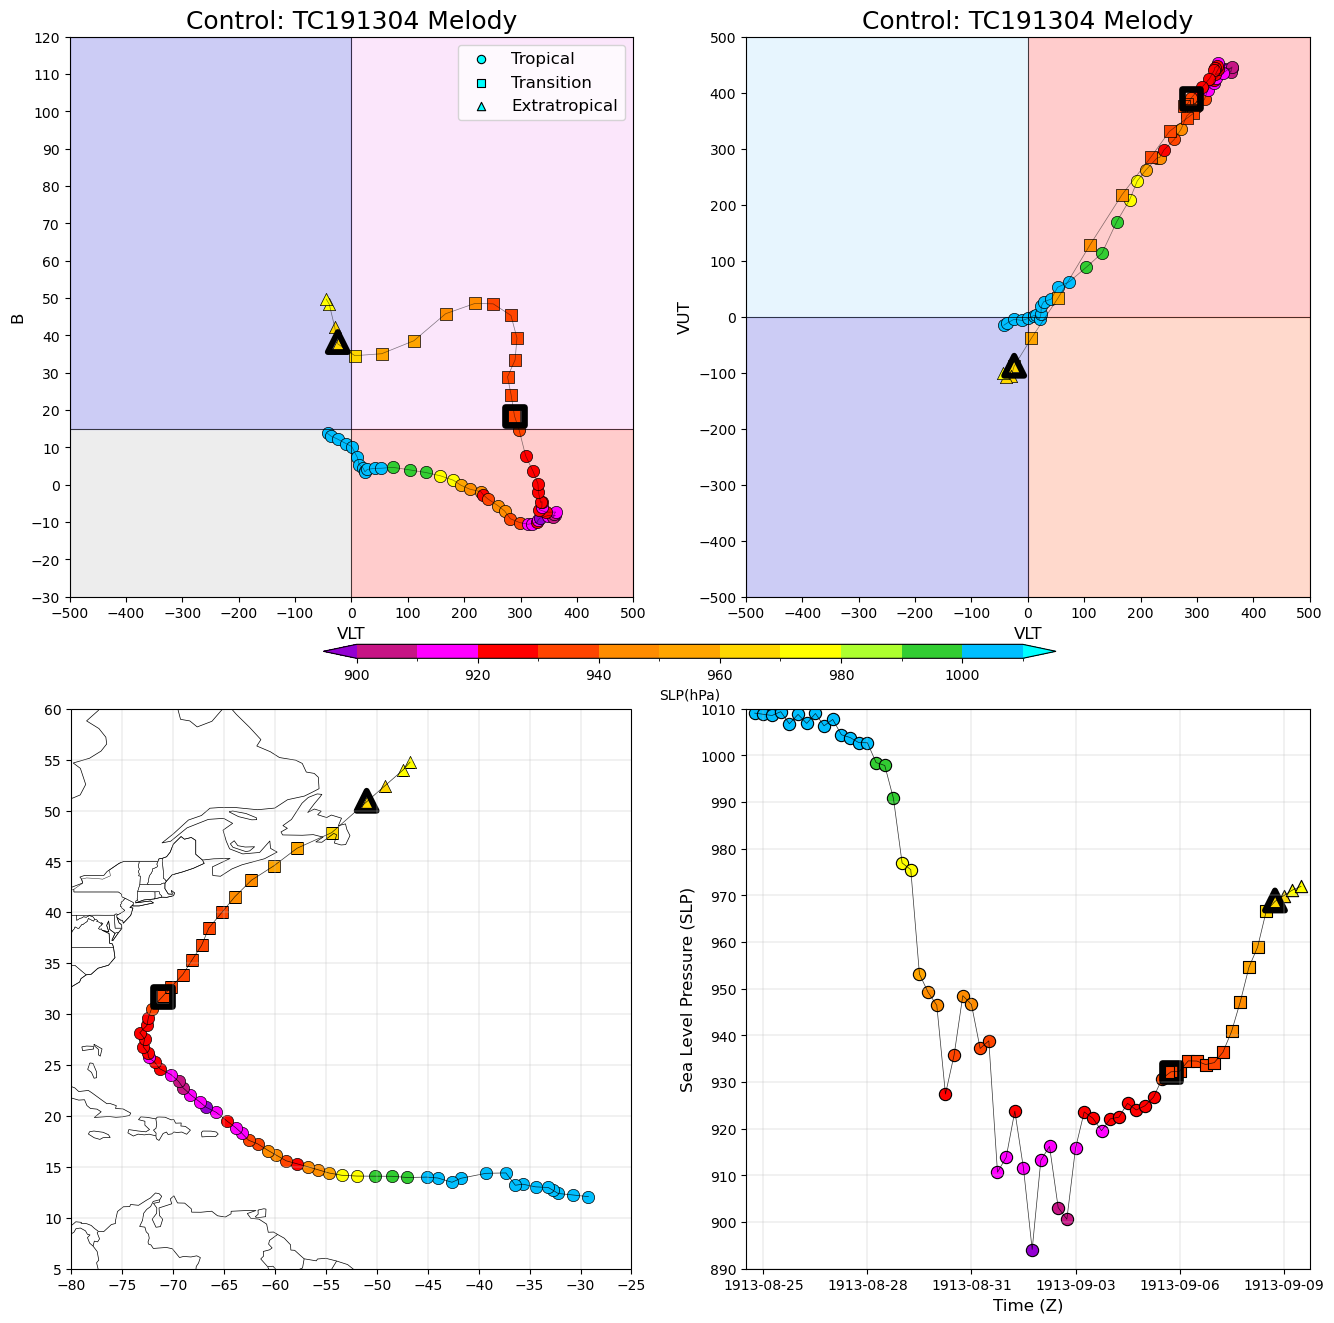

In [15]:
# Input Code
Plot_Cyclone_Info("Melody", DF_Melody, ET_Melody, SLP_Bounds, SLP_Colours, 1, True, "Control", True)

In [16]:
DF_Song = Find_Storm(RCP45_Data, "TC208507")

In [17]:
ET_Song = Find_Storm(RCP45_ET, "TC208507")

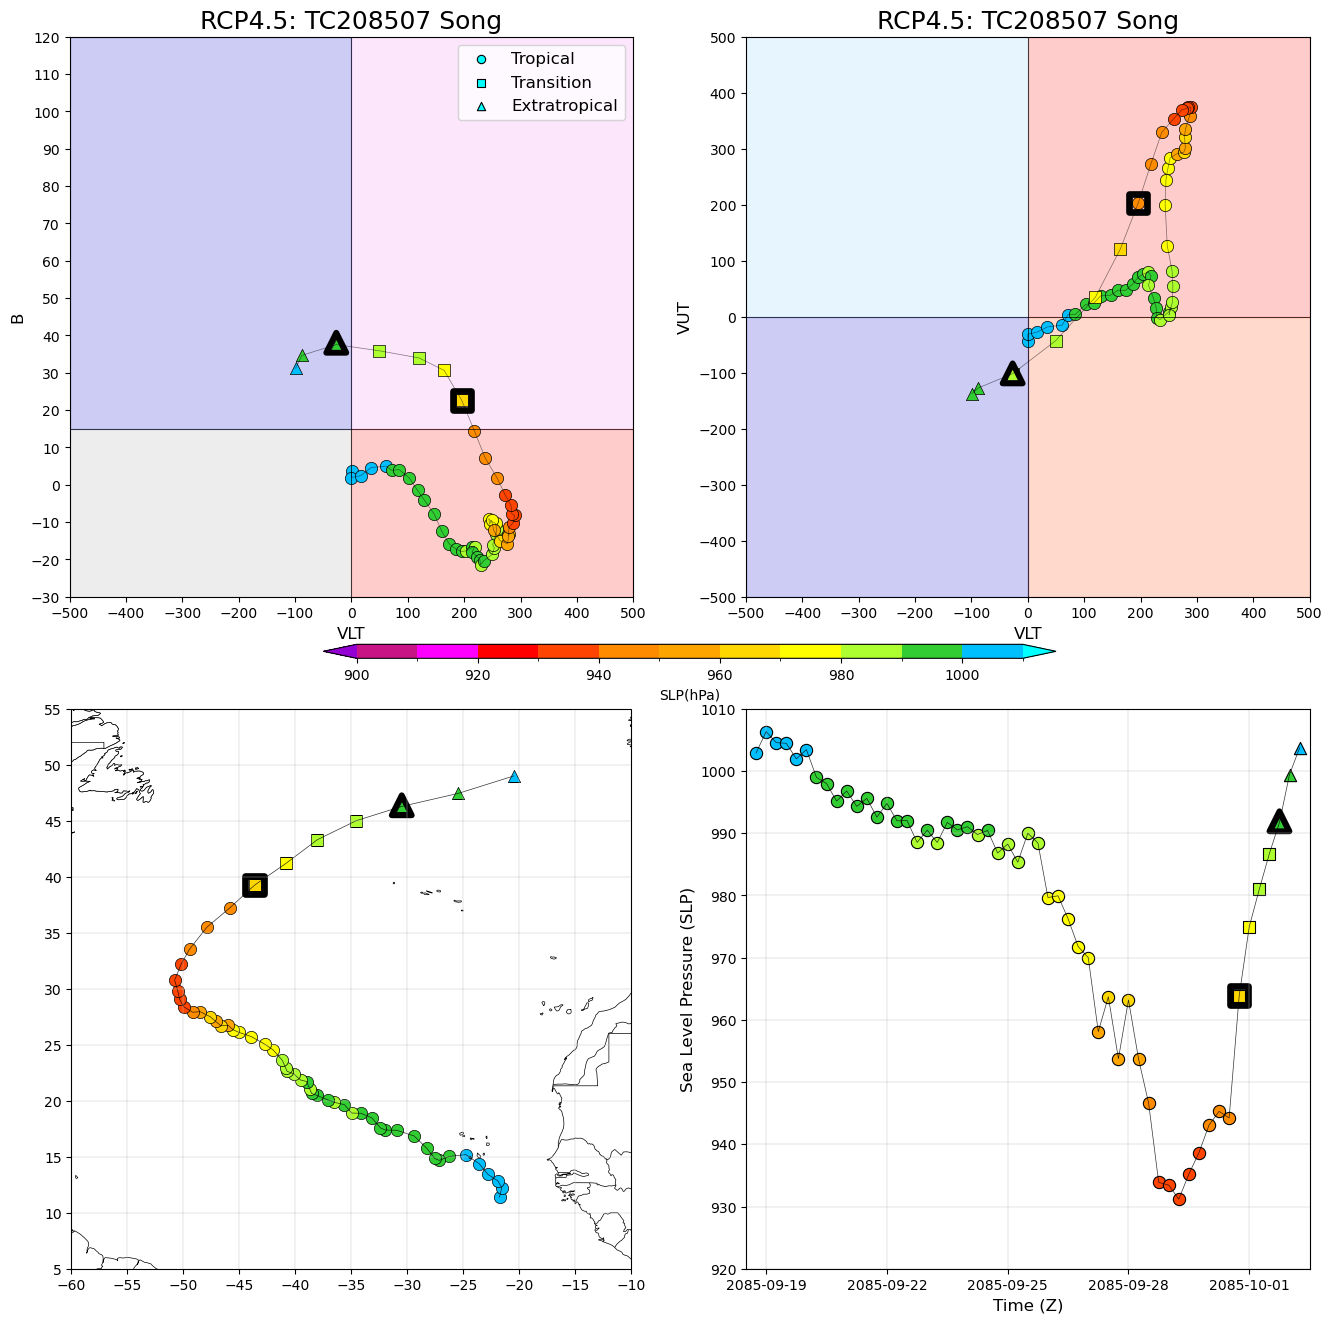

In [18]:
# Input Code
Plot_Cyclone_Info("Song", DF_Song, ET_Song, SLP_Bounds, SLP_Colours, 1, True, "RCP4.5", True)

In [19]:
DF_Rachel_1 = Find_Storm(RCP85_Data, "TC216105")

In [20]:
Rachel_Append = pandas.DataFrame({"Code":["TC216105", "TC216105", "TC216105"], "Name":["Rachel", "Rachel", "Rachel"], \
"Lon":[-56.77,-52.29,-50.18], "Lat":[48.71,53.23,54.51], "SLP(hPa)":[979.28,977.58,974.70], "Winds(m/s)":[33.0,21.6,25.3], \
"B":[72.80,75.18,72.52], "VLT":[-63.16,-155.25,-238.30], "VUT":[-92.08,-221.21,-316.20], \
"Time(Z)":[Datetime('2161-09-30 18:00:00'), Datetime('2161-10-01 00:00:00'), Datetime('2161-10-01 06:00:00')], \
"Storm Phase":["Extratropical","Extratropical","Extratropical"], "Plot Shape":['^','^','^'], \
"Plot Colour":["yellow","yellow","yellow"]})

In [21]:
DF_Rachel = pandas.concat([DF_Rachel_1, Rachel_Append]).reset_index()
DF_Rachel = DF_Rachel.drop("index", axis=1)
DF_Rachel

,Code,Name,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Time(Z),Storm Phase,Plot Shape,Plot Colour
0,TC216105,Rachel,-22.18,16.18,1009.57,12.2,11.85,-69.27,27.33,2161-09-11 18:00:00,Tropical,o,deepskyblue
1,TC216105,Rachel,-22.62,15.69,1010.28,18.0,12.32,-1.78,22.75,2161-09-12 00:00:00,Tropical,o,cyan
2,TC216105,Rachel,-22.98,16.28,1007.02,18.1,12.23,-2.26,23.06,2161-09-12 06:00:00,Tropical,o,deepskyblue
3,TC216105,Rachel,-24.45,16.80,1008.73,16.3,13.85,1.29,19.23,2161-09-12 12:00:00,Tropical,o,deepskyblue
4,TC216105,Rachel,-25.67,16.35,1006.55,16.9,15.43,11.74,19.66,2161-09-12 18:00:00,Tropical,o,deepskyblue
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,TC216105,Rachel,-63.20,44.13,958.83,42.3,64.06,63.66,169.52,2161-09-30 06:00:00,Transition,s,orange
75,TC216105,Rachel,-60.52,46.98,970.65,36.2,68.77,-9.74,50.51,2161-09-30 12:00:00,Extratropical,^,yellow
76,TC216105,Rachel,-56.77,48.71,979.28,33.0,72.80,-63.16,-92.08,2161-09-30 18:00:00,Extratropical,^,yellow
77,TC216105,Rachel,-52.29,53.23,977.58,21.6,75.18,-155.25,-221.21,2161-10-01 00:00:00,Extratropical,^,yellow


In [22]:
ET_Rachel = Find_Storm(RCP85_ET, "TC216105")

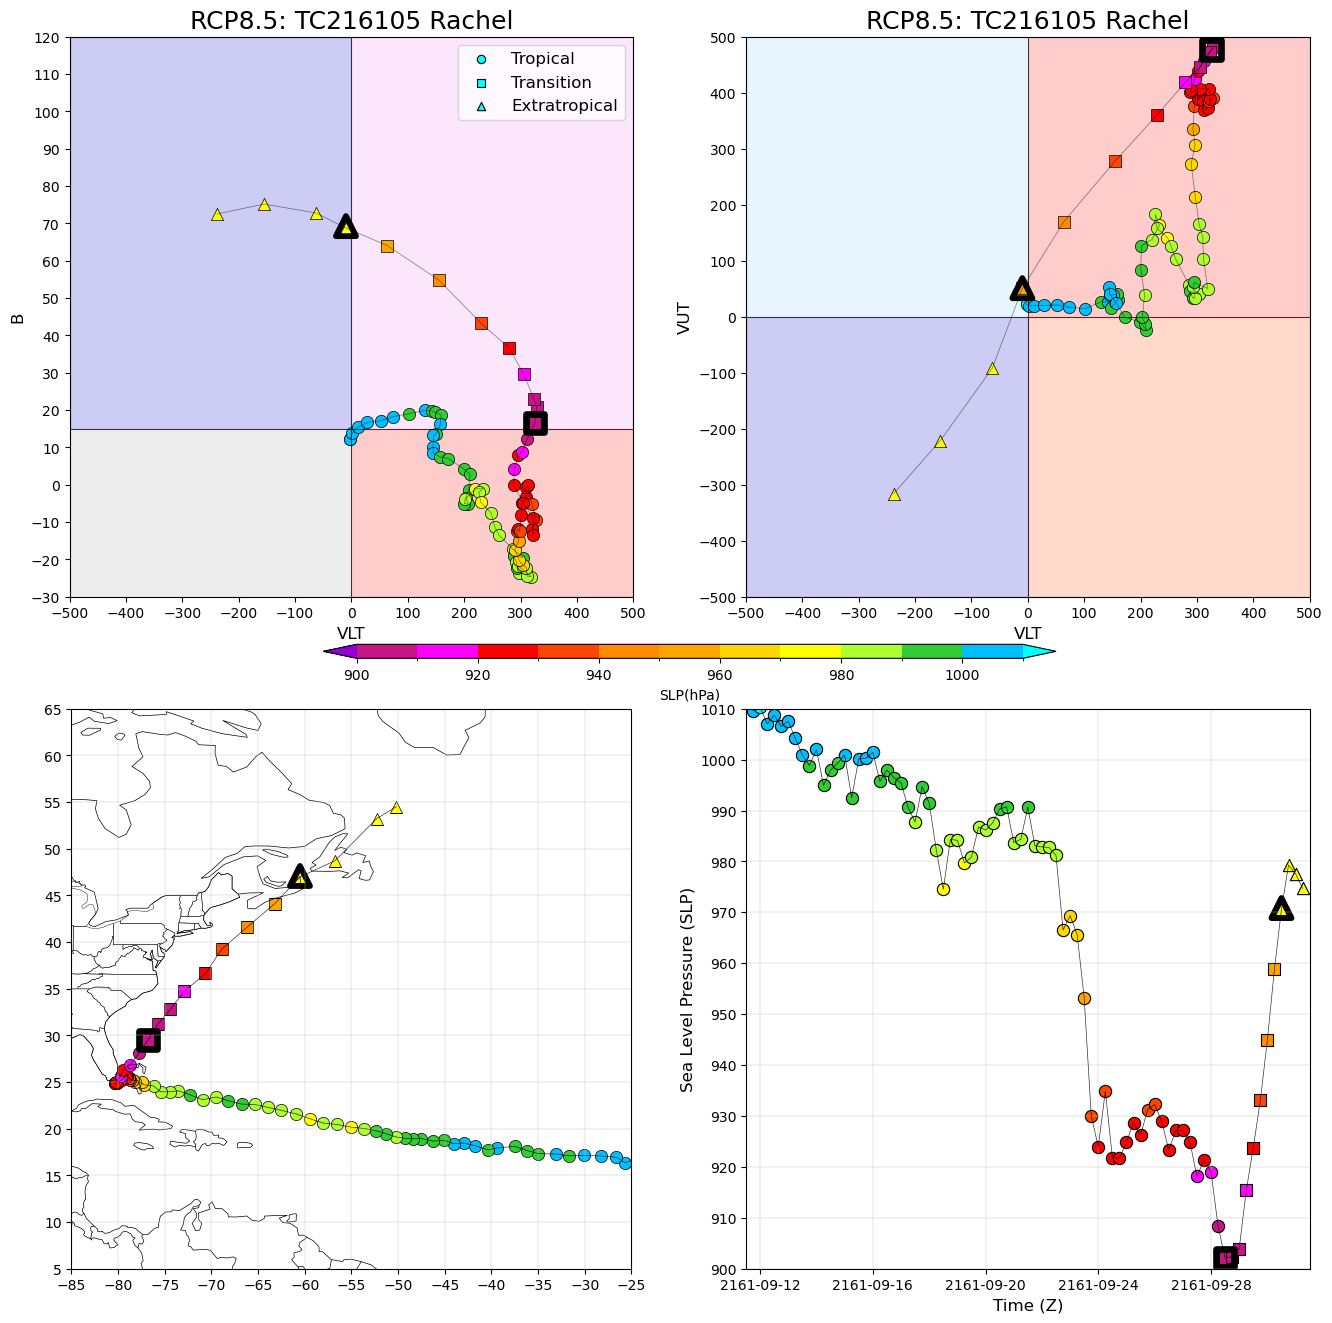

In [23]:
# Input Code
Plot_Cyclone_Info("Rachel", DF_Rachel, ET_Rachel, SLP_Bounds, SLP_Colours, 1, True, "RCP8.5", True)